In [1]:
from DataGenerator import TimeSeriesGenerator, suddenDrift, generateSeasonality, generateTrend, incrementalDrift
from conditions import scenarios
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from grouped_series import ExperimentTracker    
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from TimeSeriesGradientBoosting import TimeSeriesGradientBoosting
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression

In [3]:
onehot1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

onehot2 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

hybrid_vars = [0,1, 2, 3, 4, 5, 6, 7, -3, -2, -1]
hybrid_model = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)

hybrid_xgb_pipe = Pipeline([
    ('preprocessor', onehot1),
    ('regressor', hybrid_model)
])

sgd_pipe = Pipeline([
    ('preprocessor', onehot2),
    ('regressor', SGDRegressor())
])

In [8]:
def full_run():
    products = []
    customers = []
    for i in range(2):
        product = TimeSeriesGenerator(size=365, amountOfVariables=7)
        customer = TimeSeriesGenerator(size=365, amountOfVariables=3)
        products.append(product)
        customers.append(customer)
    thesis = ExperimentTracker(products, customers, scenarios())
    thesis.runExperiment(algorithms=[hybrid_xgb_pipe, sgd_pipe], algorithm_name=["Gradient boosted decision tree", "Linear regression"], online=[False, False])
    return thesis


In [9]:
thesis = full_run()

Finished experiment! Elapsed time: 0.456815242767334, total Elapsed time: 0.456815242767334, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Important
Finished experiment! Elapsed time: 0.5029239654541016, total Elapsed time: 0.9597392082214355, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Half observed, importance: Important
Finished experiment! Elapsed time: 0.4791865348815918, total Elapsed time: 1.4389257431030273, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Unobserved, importance: Important
Finished experiment! Elapsed time: 0.47308874130249023, total Elapsed time: 1.9120144844055176, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Medium
Finished 

In [10]:
results = thesis.resultsToDF()

In [11]:
results[["Algorithm","SMAPE", "Drift type", "Drift time", "Drift magnitude"]].groupby(["Algorithm","Drift type", "Drift time", "Drift magnitude"]).aggregate(["mean", "std", "min", "max"])

SMAPE  \
                                                                                      mean   
Algorithm                      Drift type        Drift time     Drift magnitude              
Gradient boosted decision tree Incremental Drift Fully observed Large             5.162500   
                                                                Small             2.589167   
                                                 Half observed  Large            10.170833   
                                                                Small             3.237500   
                                                 Unobserved     Large            10.816667   
                                                                Small             3.444167   
                               No Drift          No Drift       No Drift          2.127500   
                               Sudden Drift      Fully observed Large             4.794167   
                                                                Small             2.541667   
                                                 Half observed  Large             7.504167   
                                                                Small             2.895833   
                                                 Unobserved     Large            12.870833   
                                                                Small             3.796667   
                               Sudden Shock      3 days         Large             2.475000   
                                                                Small             2.182500   
                                                 7 days         Large             2.500000   
                                                                Small             2.282500   
Linear regression              Incremental Drift Fully observed Large             3.638333   
                                                                Small             2.738333   
                                                 Half observed  Large             4.966667   
                                                                Small             3.137500   
                                                 Unobserved     Large            10.066667   
                                                                Small             3.815833   
                               No Drift          No Drift       No Drift          2.640000   
                               Sudden Drift      Fully observed Large             3.651667   
                                                                Small             2.745833   
                                                 Half observed  Large             4.404167   
                                                                Small             2.878333   
                                                 Unobserved     Large            12.360000   
                                                                Small             4.220833   
                               Sudden Shock      3 days         Large             2.767500   
                                                                Small             2.685000   
                                                 7 days         Large             2.772500   
                                                                Small             2.690000   

                                                                                           \
                                                                                      std   
Algorithm                      Drift type        Drift time     Drift magnitude             
Gradient boosted decision tree Incremental Drift Fully observed Large            1.722282   
                                                                Small            0.347836   
                                                 Half observed  Large            4.560332   
                                                

In [ ]:
results.sort_values("SMAPE", ascending=False)   

,Algorithm,Dropped variable,Drift type,Drift magnitude,Variable importance,Drift time,MSE,SMAPE
318,Linear regression,6.0,Incremental Drift,Large,Medium,Half observed,3989.357610,31.23
298,Linear regression,6.0,Sudden Drift,Large,Important,Unobserved,2908.873203,29.40
274,Linear regression,3.0,Incremental Drift,Large,Important,Half observed,3304.612637,27.70
257,Linear regression,3.0,Sudden Drift,Large,Important,Unobserved,2344.068765,25.93
219,Linear regression,0.0,Sudden Drift,Large,Medium,Unobserved,2227.529124,25.33
...,...,...,...,...,...,...,...,...
147,Gradient boosted decision tree,6.0,Incremental Drift,Small,Unimportant,Fully observed,19.400639,2.03
6,Gradient boosted decision tree,NaN,Sudden Drift,Small,Unimportant,Fully observed,19.198601,2.02
24,Gradient boosted decision tree,NaN,Incremental Drift,Small,Unimportant,Fully observed,19.089016,2.00
36,Gradient boosted decision tree,NaN,No Drift,No Drift,No Drift,No Drift,20.391299,2.00


Next up is changepoint/drift detection!
Let's start with doing it on a single series and then ramp up complexity to multivariate cases

In [98]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

In [99]:
test_prod = TimeSeriesGenerator(size=365, amountOfVariables=10)
#generateTrend(test_prod, indices=1, magnitude=3)
#suddenDrift(test_prod, variables=0, magnitude=3, time=140)
generateSeasonality(test_prod, 6, 2)
test_prod = test_prod.toDataFrame()
test_prod = test_prod.astype(float)

In [100]:
tsd = TimeSeriesData(value= test_prod["Response"], time = test_prod.index)


In [101]:
det = BOCPDetector(tsd)
changepoint = det.detector(threshold=0.9)

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



In [102]:
changepoint

[BOCPDChangePoint(start_time: 2017-03-04T00:00:00.000000000, end_time: 2017-03-04T00:00:00.000000000, confidence: 0.9220206647115643, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response),
 BOCPDChangePoint(start_time: 2017-04-01T00:00:00.000000000, end_time: 2017-04-01T00:00:00.000000000, confidence: 0.9164107165878294, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response),
 BOCPDChangePoint(start_time: 2017-06-01T00:00:00.000000000, end_time: 2017-06-01T00:00:00.000000000, confidence: 0.9302759190478884, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response),
 BOCPDChangePoint(start_time: 2017-12-12T00:00:00.000000000, end_time: 2017-12-12T00:00:00.000000000, confidence: 0.9186729093410662, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response)]

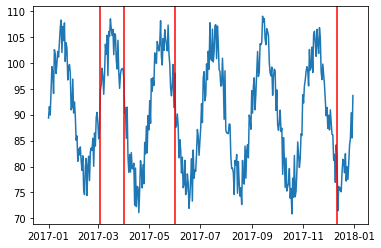

In [103]:
det.plot(changepoint);

In [104]:
test_prod.iloc[[110]]

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-04-21,23.922557,15.405197,1.647289,10.17807,21.206997,20.36105,10.015101,13.228119,29.106022,18.087705,81.129251,2017.0,16.0,5.0
